
## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn
from torch.utils.data.sampler import SubsetRandomSampler

import sys,os
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/"))
from imp import reload 
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *
import mist_utils
reload(mist_utils)
from mist_utils import *

import warnings
warnings.filterwarnings('ignore')

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu' # temporarily
# Fix random seeds for reproducibility
seed = 73
#torch.manual_seed(seed)
#np.random.seed(seed)a


In [10]:
import sys,os 
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/myutils/"))
from plt_utils import generateAxesForMultiplePlots, remove_inner_axes
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import chi2_contingency

Text(0, 0.5, '$\\Omega_\\mathrm{m, pred}$')

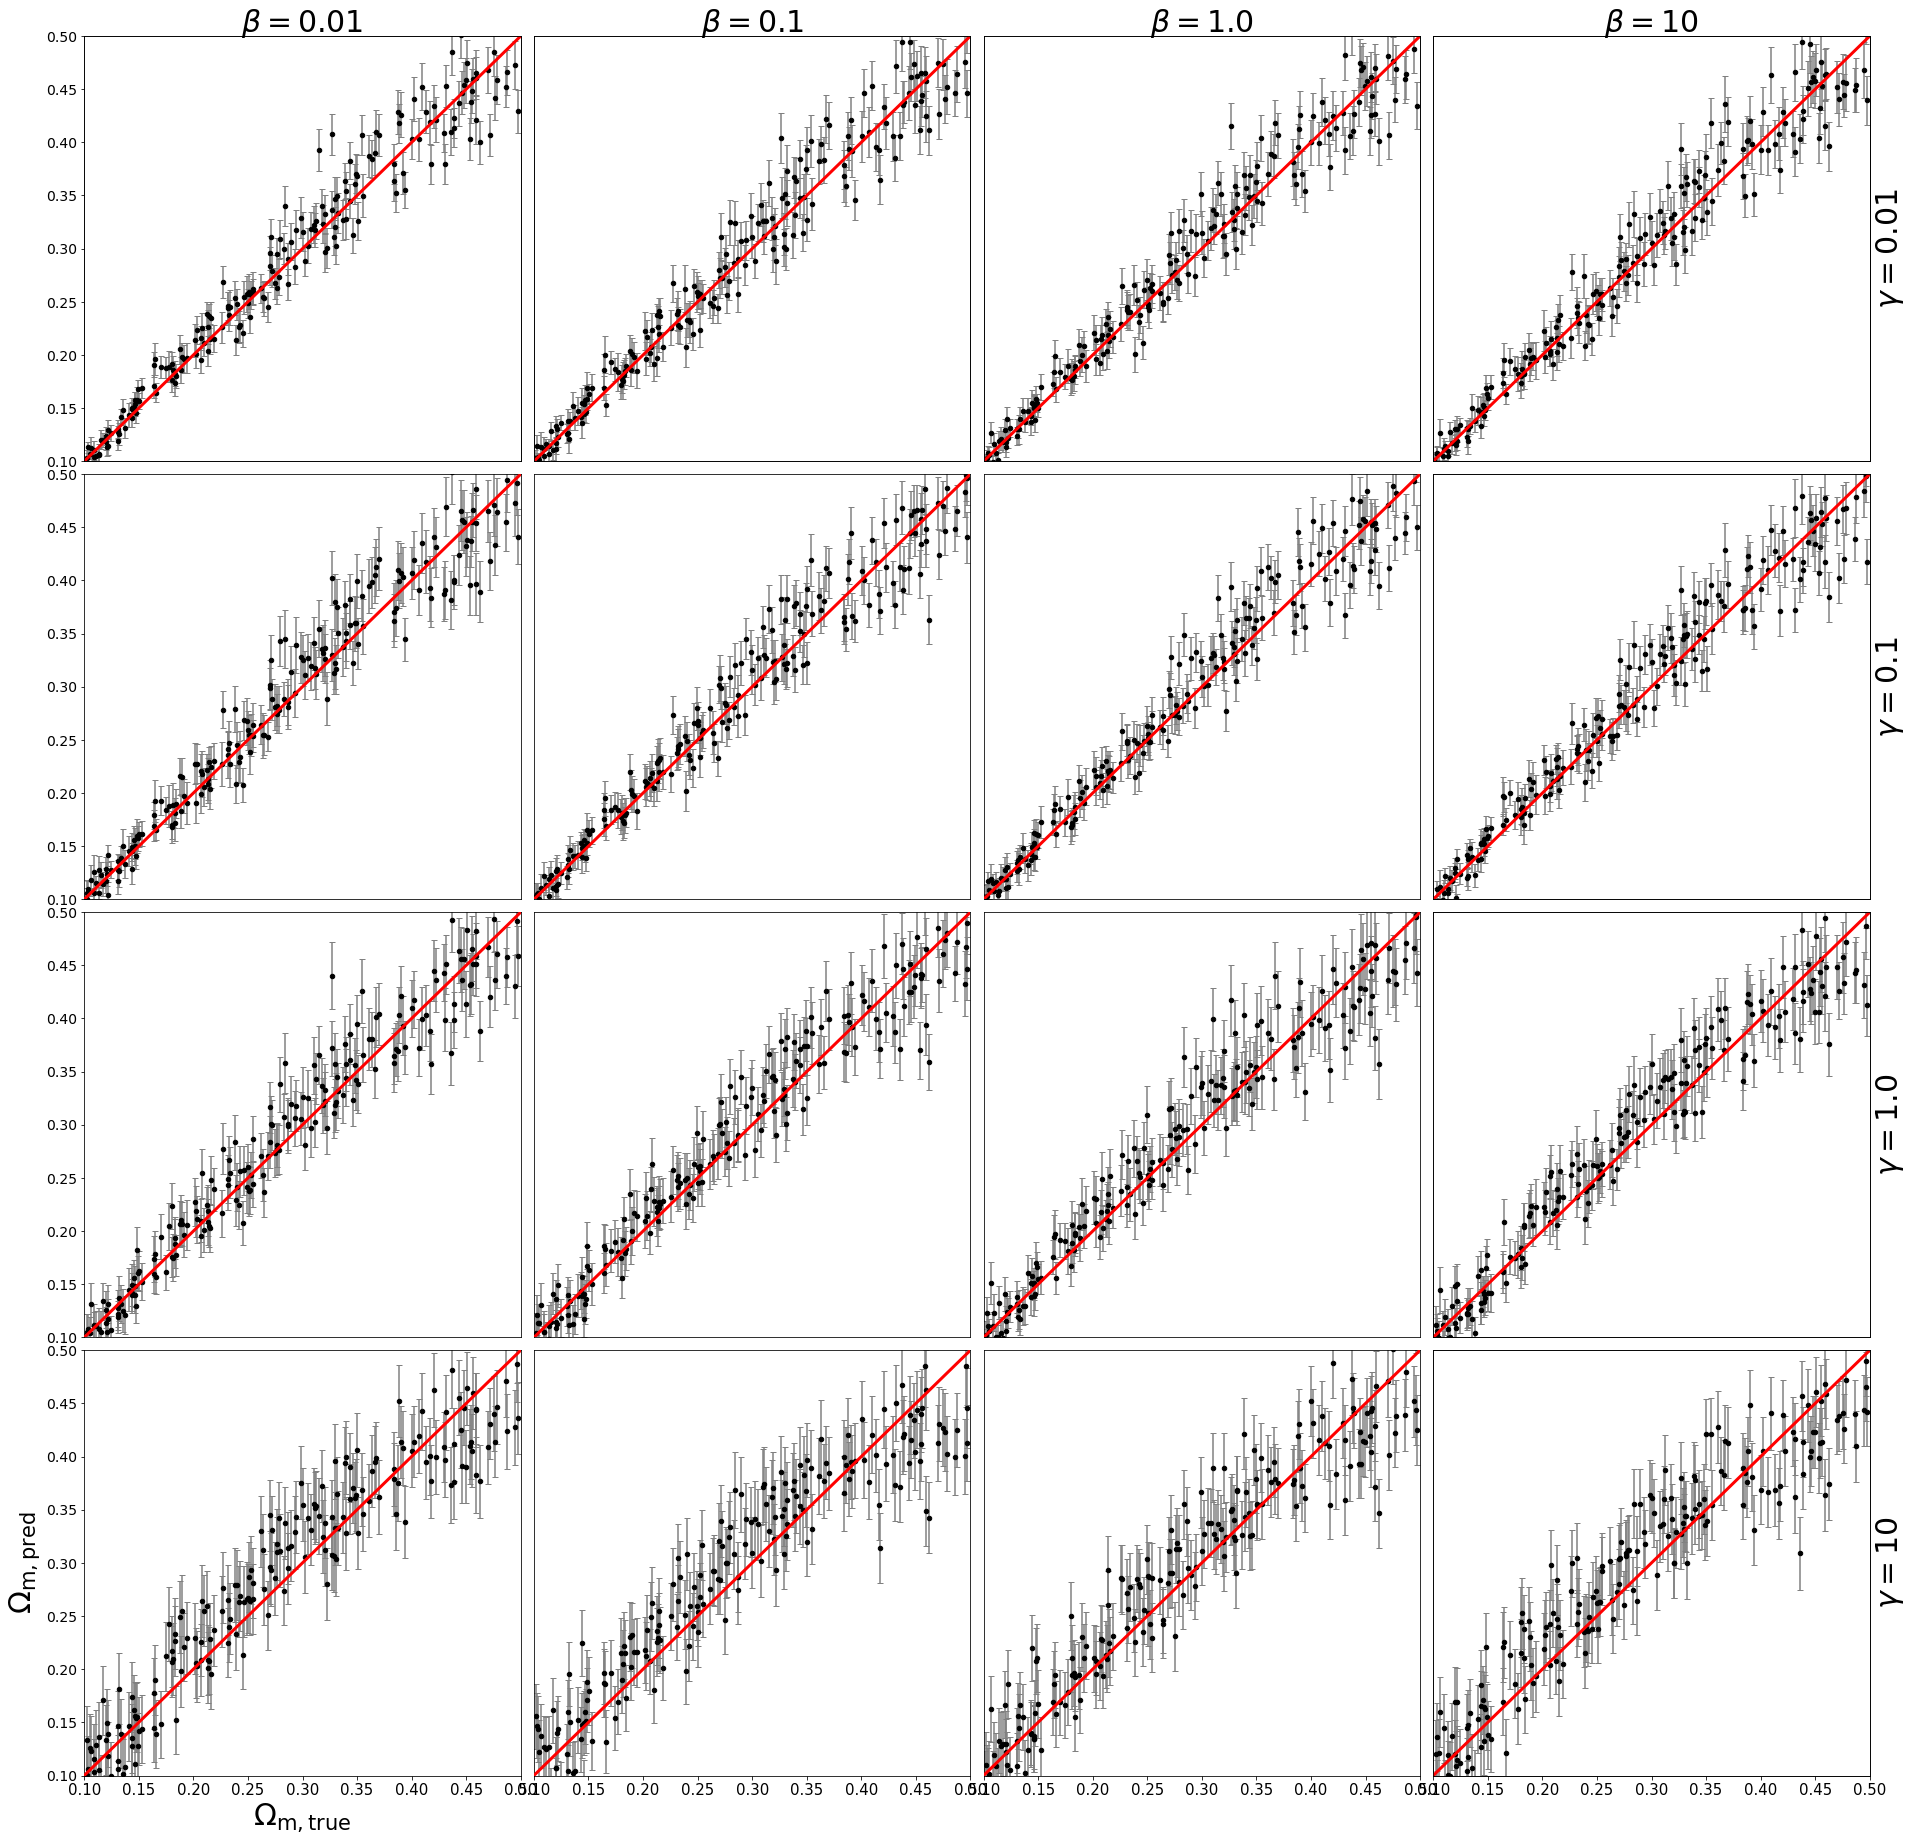

In [5]:
field = 'HI';

fig_shape = (4,4)
axes = generateAxesForMultiplePlots(shape=fig_shape,figsize=(32,32),wspace=0.03,hspace=0.03)
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fontsize = 30
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.2,1.2,3)


betas  = [0.01,0.1,1.0,10]
gammas = [0.01,0.1,1.0,10]

l = 0; # mean TNG
for i in range(4):
    for j in range(4):
        beta, gamma = betas[i], gammas[j]
        fname = "search/TNG+SIMBA_{}_beta_{}_gamma_{}".format(field, beta, gamma)
        mist = MIST(sim=["TNG","SIMBA"],field=field, extended_L=False)
        mist.load_models(which_machine='vib+cls', fname=fname, z_dim=1000)
        y_true, y_pred = mist.make_plots(show_plot=False, data_return=True)
        axes[i,j].errorbar(y_true[l][:,0], y_pred[l][0][:,0], y_pred[l][1][:,0],linestyle="None",ecolor="grey",
                         capsize=3,zorder=0)
        axes[i,j].scatter(y_true[l][:,0], y_pred[l][0][:,0],s=20,c='k', zorder=10)
        axes[i,j].plot(ideal1,ideal1,"r",lw=3,zorder=12)
        remove_inner_axes(axes,fig_shape)
        axes[i,j].set_xlim(0.1,0.5)
        axes[i,j].set_ylim(0.1,0.5)
        if j == 0:
            ax = axes[i,j].twiny()
            ax.xaxis.tick_top()
            ax.set_xticks([])
            ax.set_xlabel(r"$\beta={}$".format(beta),fontsize=fontsize)
        if i == 3:
            ax = axes[i,j].twinx()
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel(r"$\gamma={}$".format(gamma),fontsize=fontsize)
axes[0,3].set_xlabel("$\Omega_\mathrm{m, true}$", fontsize=fontsize)
axes[0,3].set_ylabel("$\Omega_\mathrm{m, pred}$", fontsize=fontsize)
#plt.savefig("Exploration_HI_omegam_TNG.png", dpi=200, bbox_inches='tight')

In [14]:
field = ['HI','ne'];
field_name = 'HI_ne'
fe=0.3;fd=0.6;z_dim=400;dr=0.1

betas  = [0.1,1,10,100]
gammas = [0.001, 0.01,0.1,1]
betas  = [1,10,100]
gammas = [0.01,0.1,1]
data = np.empty((4,4),dtype=object)
for i in range(len(betas)):
    for j in range(len(gammas)):
        beta, gamma = betas[i], gammas[j]
        fname = "search/TNG_SIMBA_{}_b_{}_g_{}".format(field_name, beta, gamma)
        mist = MIST(sim=["TNG","SIMBA"],field=field, L=4, dn=0, 
                    monopole=True, normalization=True, average=False, projection=True)
        mist.load_models(which_machine='vib+cls', fname=fname, z_dim=z_dim, hidden1=fe, hidden2=fd,dr=dr)
        #mist.make_plots(show_plot=True)
        plt.show()
        y_true, y_pred = mist.test_on(sims="ASTRID", fname="0.01", data_return=True,show_plot=False, 
                                      show_score=False, save_plot=False)
        data[i,j] = (y_true, y_pred)

Text(0, 0.5, '$\\Omega_\\mathrm{m, pred}$')

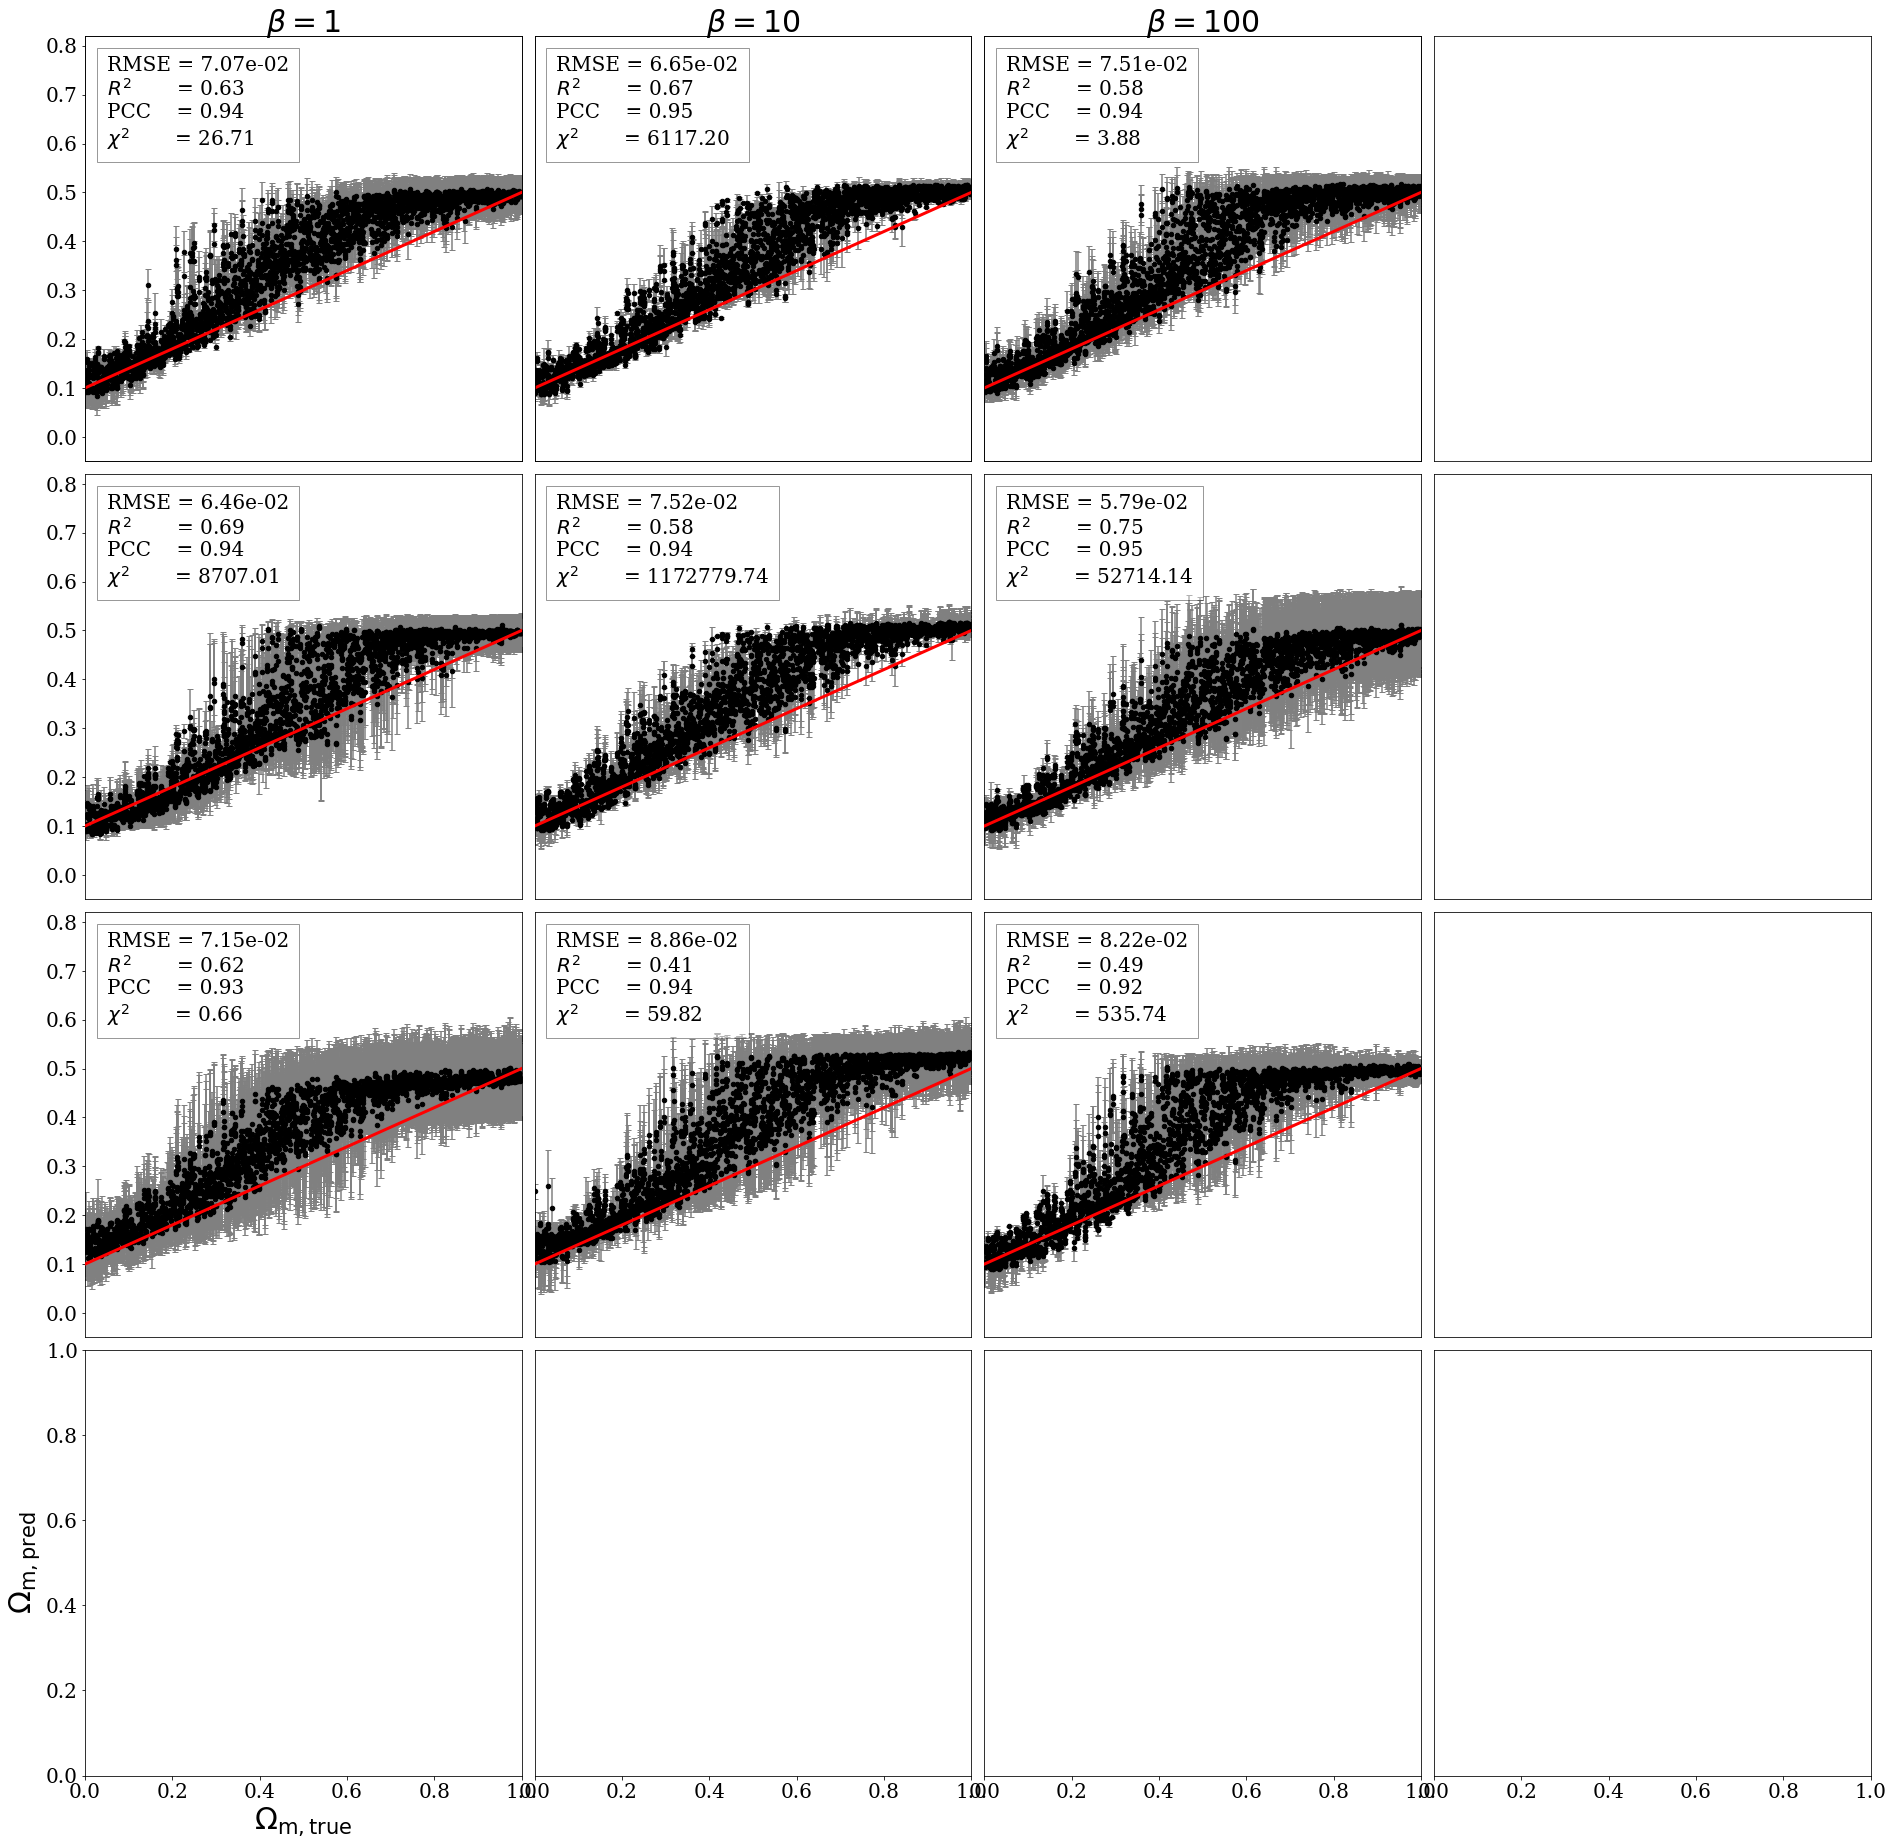

In [16]:
fig_shape = (4,4)
axes = generateAxesForMultiplePlots(shape=fig_shape,figsize=(32,32),wspace=0.03,hspace=0.03)
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fontsize = 30
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.2,1.2,3)


#betas  = [1,10,100]
#gammas = [ 0.01,0.1,1]

for i in range(len(betas)):
    for j in range(len(gammas)):
        beta, gamma = betas[i], gammas[j]
        y_true, y_pred = data[i,j]
        axes[i,j].errorbar(y_true[:,0], y_pred[0][:,0], y_pred[1][:,0],linestyle="None",ecolor="grey",
                         capsize=3,zorder=0)
        axes[i,j].scatter(y_true[:,0], y_pred[0][:,0],s=20,c='k', zorder=10)
        axes[i,j].plot(ideal1,ideal1,"r",lw=3,zorder=12)
        RMSE = np.sqrt(mean_squared_error(y_true[:,0], y_pred[0][:,0]))
        R2   = r2_score(y_true[:,0], y_pred[0][:,0])
        PCC  = pearsonr(y_true[:,0], y_pred[0][:,0])[0]
        CHI2 = np.mean((y_true[:,0]-y_pred[0][:,0])**2/y_pred[1][:,0]**2)
        text_om = \
        r"""{:<5}= {:.2e}
{:<12}= {:.2f}
{:<7}= {:.2f}
{:<15}= {:.2f}""".format("RMSE", RMSE,"$R^2$", R2,
                            "PCC", PCC, "$\chi^2$", CHI2)
        axes[i,j].text(0.12, 0.78, text_om, fontsize=20,
                       ha='left', va='top',bbox=dict(facecolor='white', alpha=0.4,pad=10),zorder=12)
    
        remove_inner_axes(axes,fig_shape)
        axes[i,j].set_xlim(0.1,0.5)
        axes[i,j].set_ylim(-0.05,0.82) #(0.1,0.5)#
        if j == 0:
            ax = axes[i,j].twiny()
            ax.xaxis.tick_top()
            ax.set_xticks([])
            ax.set_xlabel(r"$\beta={}$".format(beta),fontsize=fontsize)
        if i == 3:
            ax = axes[i,j].twinx()
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel(r"$\gamma={}$".format(gamma),fontsize=fontsize)
axes[0,3].set_xlabel(r"$\Omega_\mathrm{m, true}$", fontsize=fontsize)
axes[0,3].set_ylabel(r"$\Omega_\mathrm{m, pred}$", fontsize=fontsize)
#plt.savefig("Exploration_HI_omegam.png", dpi=200, bbox_inches='tight')

In [20]:
field = 'HI';

betas  = [0.01,0.1,1.0,10]
gammas = [0.01,0.1,1.0,10]
data = np.empty((4,4),dtype=object)
for i in range(4):
    for j in range(4):
        beta, gamma = betas[i], gammas[j]
        fname = "search/TNG+SIMBA_{}_beta_{}_gamma_{}".format(field, beta, gamma)
        mist = MIST(sim=["TNG","SIMBA"],field=field, extended_L=False)
        mist.load_models(which_machine='vib+cls', fname=fname, z_dim=1000)
        y_true, y_pred = mist.test_on(sims="ASTRID", fname="0.01", data_return=True,show_plot=False, show_score=False, save_plot=False)
        data[i,j] = (y_true, y_pred)

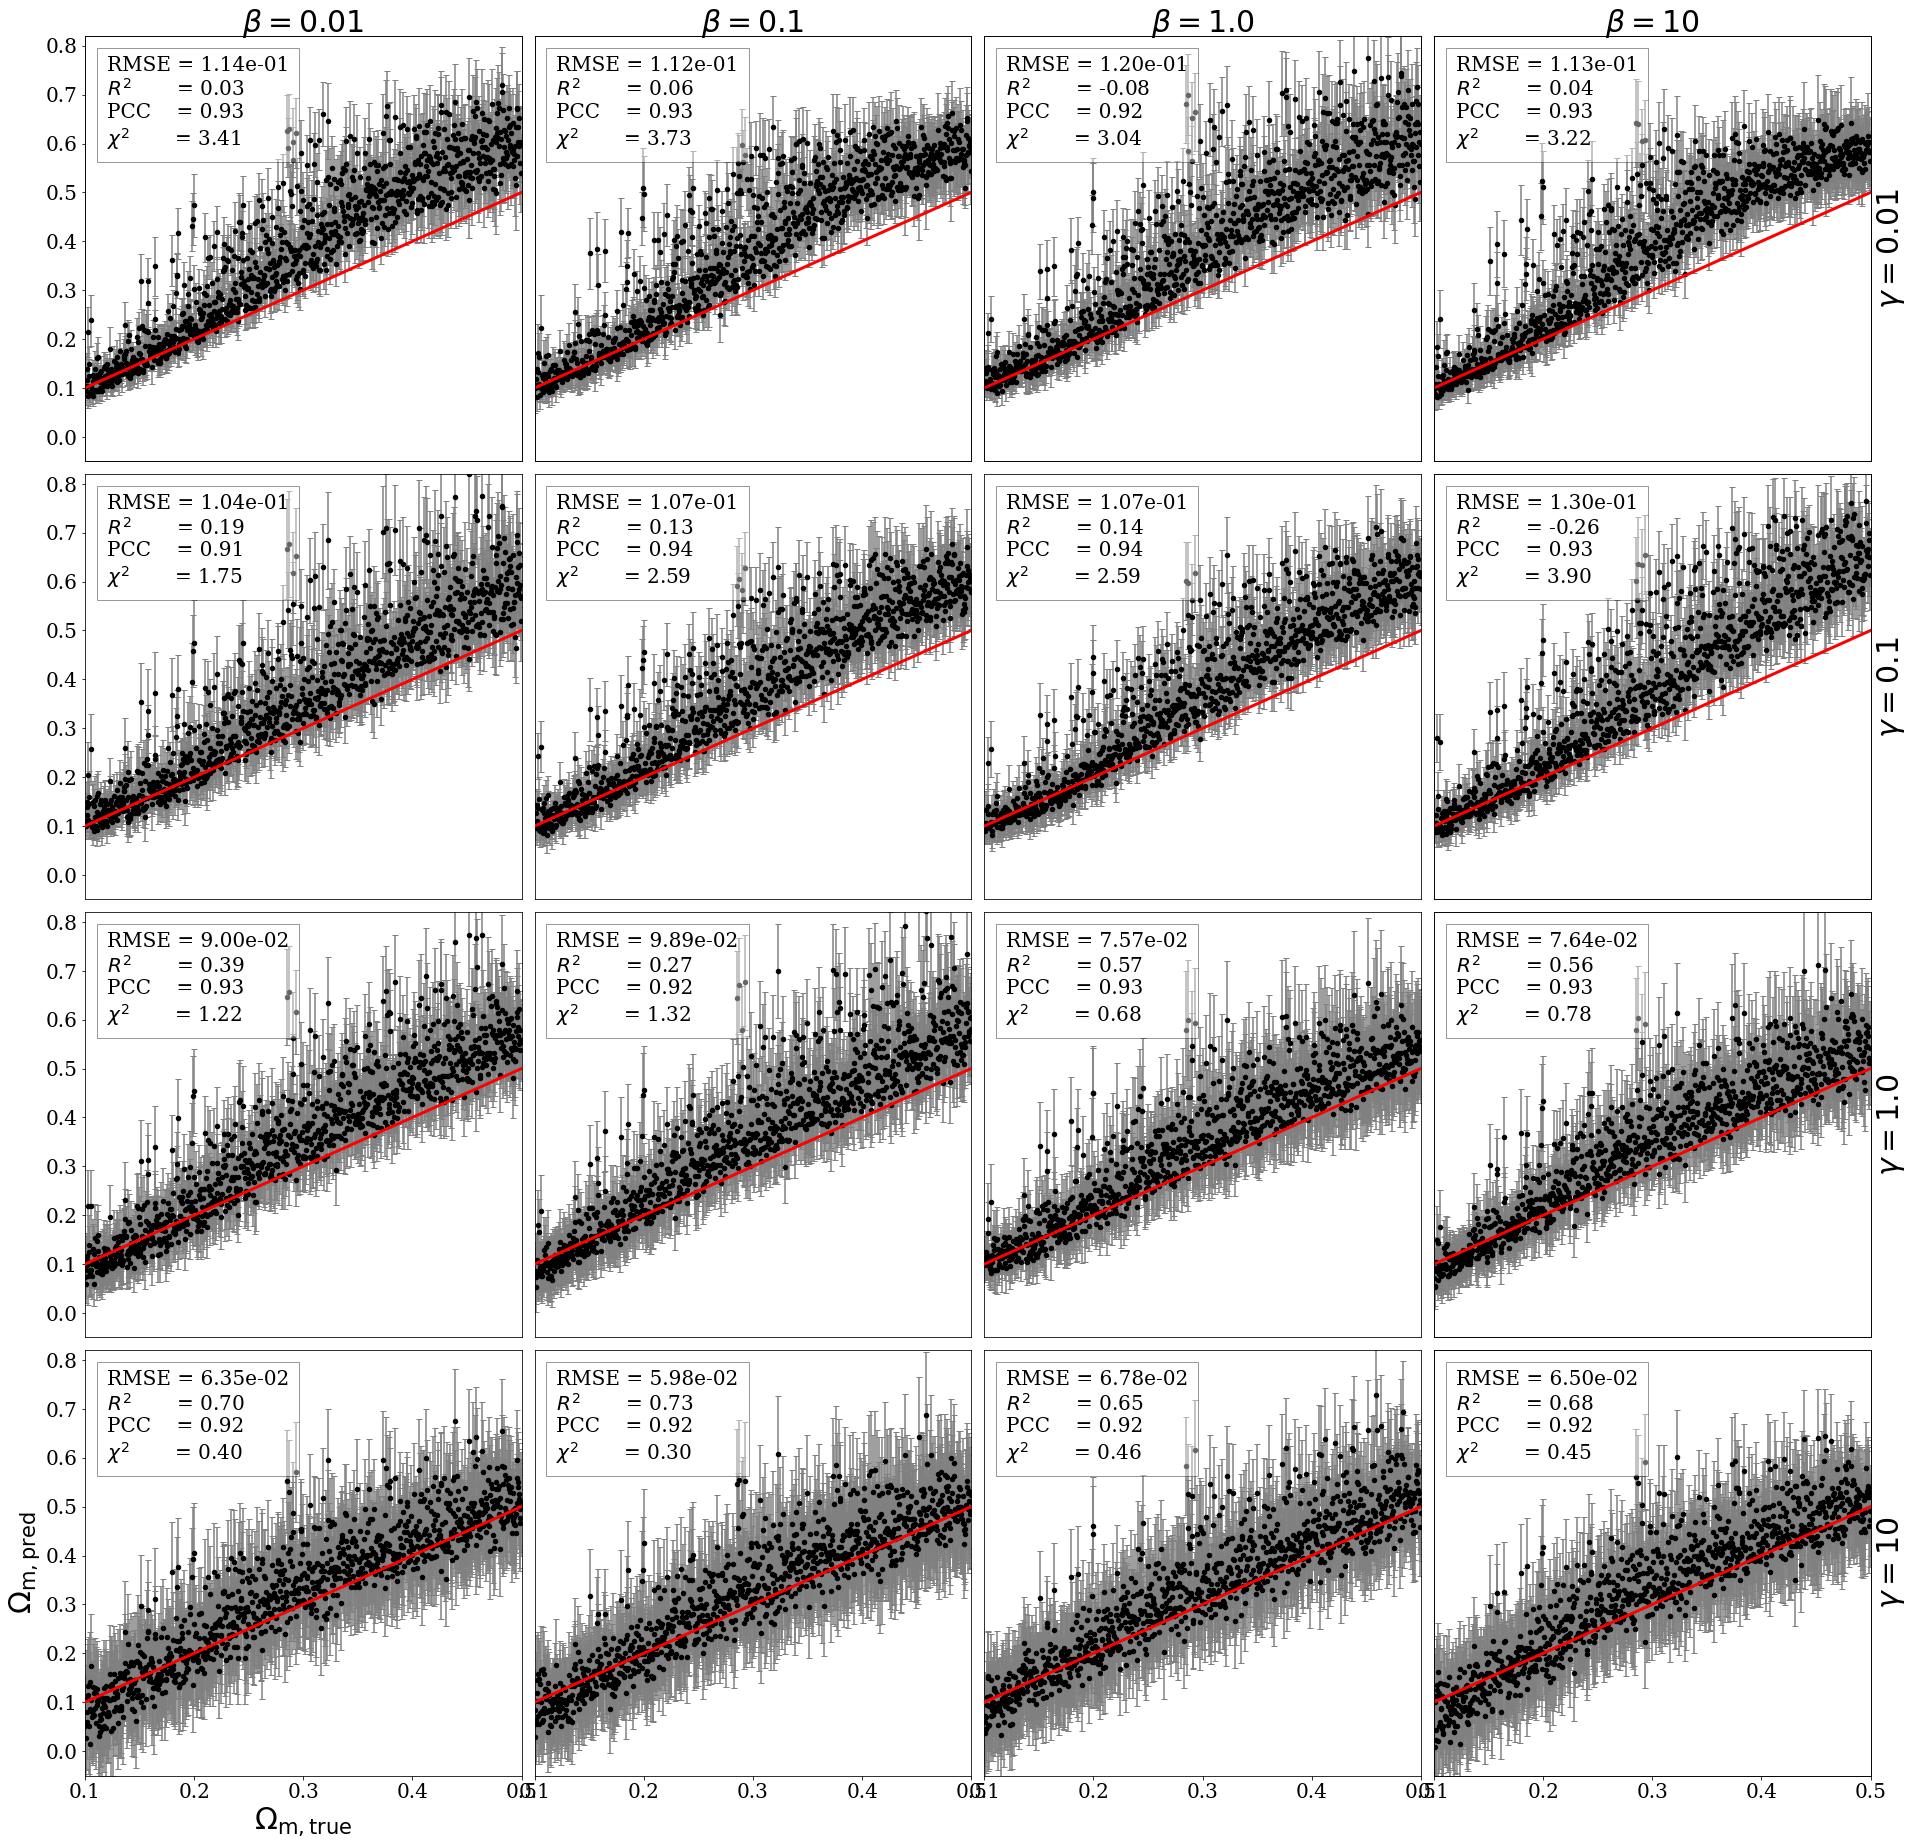

In [ ]:
fig_shape = (4,4)
axes = generateAxesForMultiplePlots(shape=fig_shape,figsize=(32,32),wspace=0.03,hspace=0.03)
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fontsize = 30
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.2,1.2,3)


betas  = [0.01,0.1,1.0,10]
gammas = [0.01,0.1,1.0,10]

for i in range(4):
    for j in range(4):
        beta, gamma = betas[i], gammas[j]
        y_true, y_pred = data[i,j]
        axes[i,j].errorbar(y_true[:,0], y_pred[0][:,0], y_pred[1][:,0],linestyle="None",ecolor="grey",
                         capsize=3,zorder=0)
        axes[i,j].scatter(y_true[:,0], y_pred[0][:,0],s=20,c='k', zorder=10)
        axes[i,j].plot(ideal1,ideal1,"r",lw=3,zorder=12)
        RMSE = np.sqrt(mean_squared_error(y_true[:,0], y_pred[0][:,0]))
        R2   = r2_score(y_true[:,0], y_pred[0][:,0])
        PCC  = pearsonr(y_true[:,0], y_pred[0][:,0])[0]
        CHI2 = np.mean((y_true[:,0]-y_pred[0][:,0])**2/y_pred[1][:,0]**2)
        text_om = \
        r"""{:<5}= {:.2e}
{:<12}= {:.2f}
{:<7}= {:.2f}
{:<15}= {:.2f}""".format("RMSE", RMSE,"$R^2$", R2,
                            "PCC", PCC, "$\chi^2$", CHI2)
        axes[i,j].text(0.12, 0.78, text_om, fontsize=20,
                       ha='left', va='top',bbox=dict(facecolor='white', alpha=0.4,pad=10),zorder=12)
    
        remove_inner_axes(axes,fig_shape)
        axes[i,j].set_xlim(0.1,0.5)
        axes[i,j].set_ylim(-0.05,0.82)
        if j == 0:
            ax = axes[i,j].twiny()
            ax.xaxis.tick_top()
            ax.set_xticks([])
            ax.set_xlabel(r"$\beta={}$".format(beta),fontsize=fontsize)
        if i == 3:
            ax = axes[i,j].twinx()
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel(r"$\gamma={}$".format(gamma),fontsize=fontsize)
axes[0,3].set_xlabel(r"$\Omega_\mathrm{m, true}$", fontsize=fontsize)
axes[0,3].set_ylabel(r"$\Omega_\mathrm{m, pred}$", fontsize=fontsize)
plt.savefig("Exploration_HI_omegam.png", dpi=200, bbox_inches='tight')

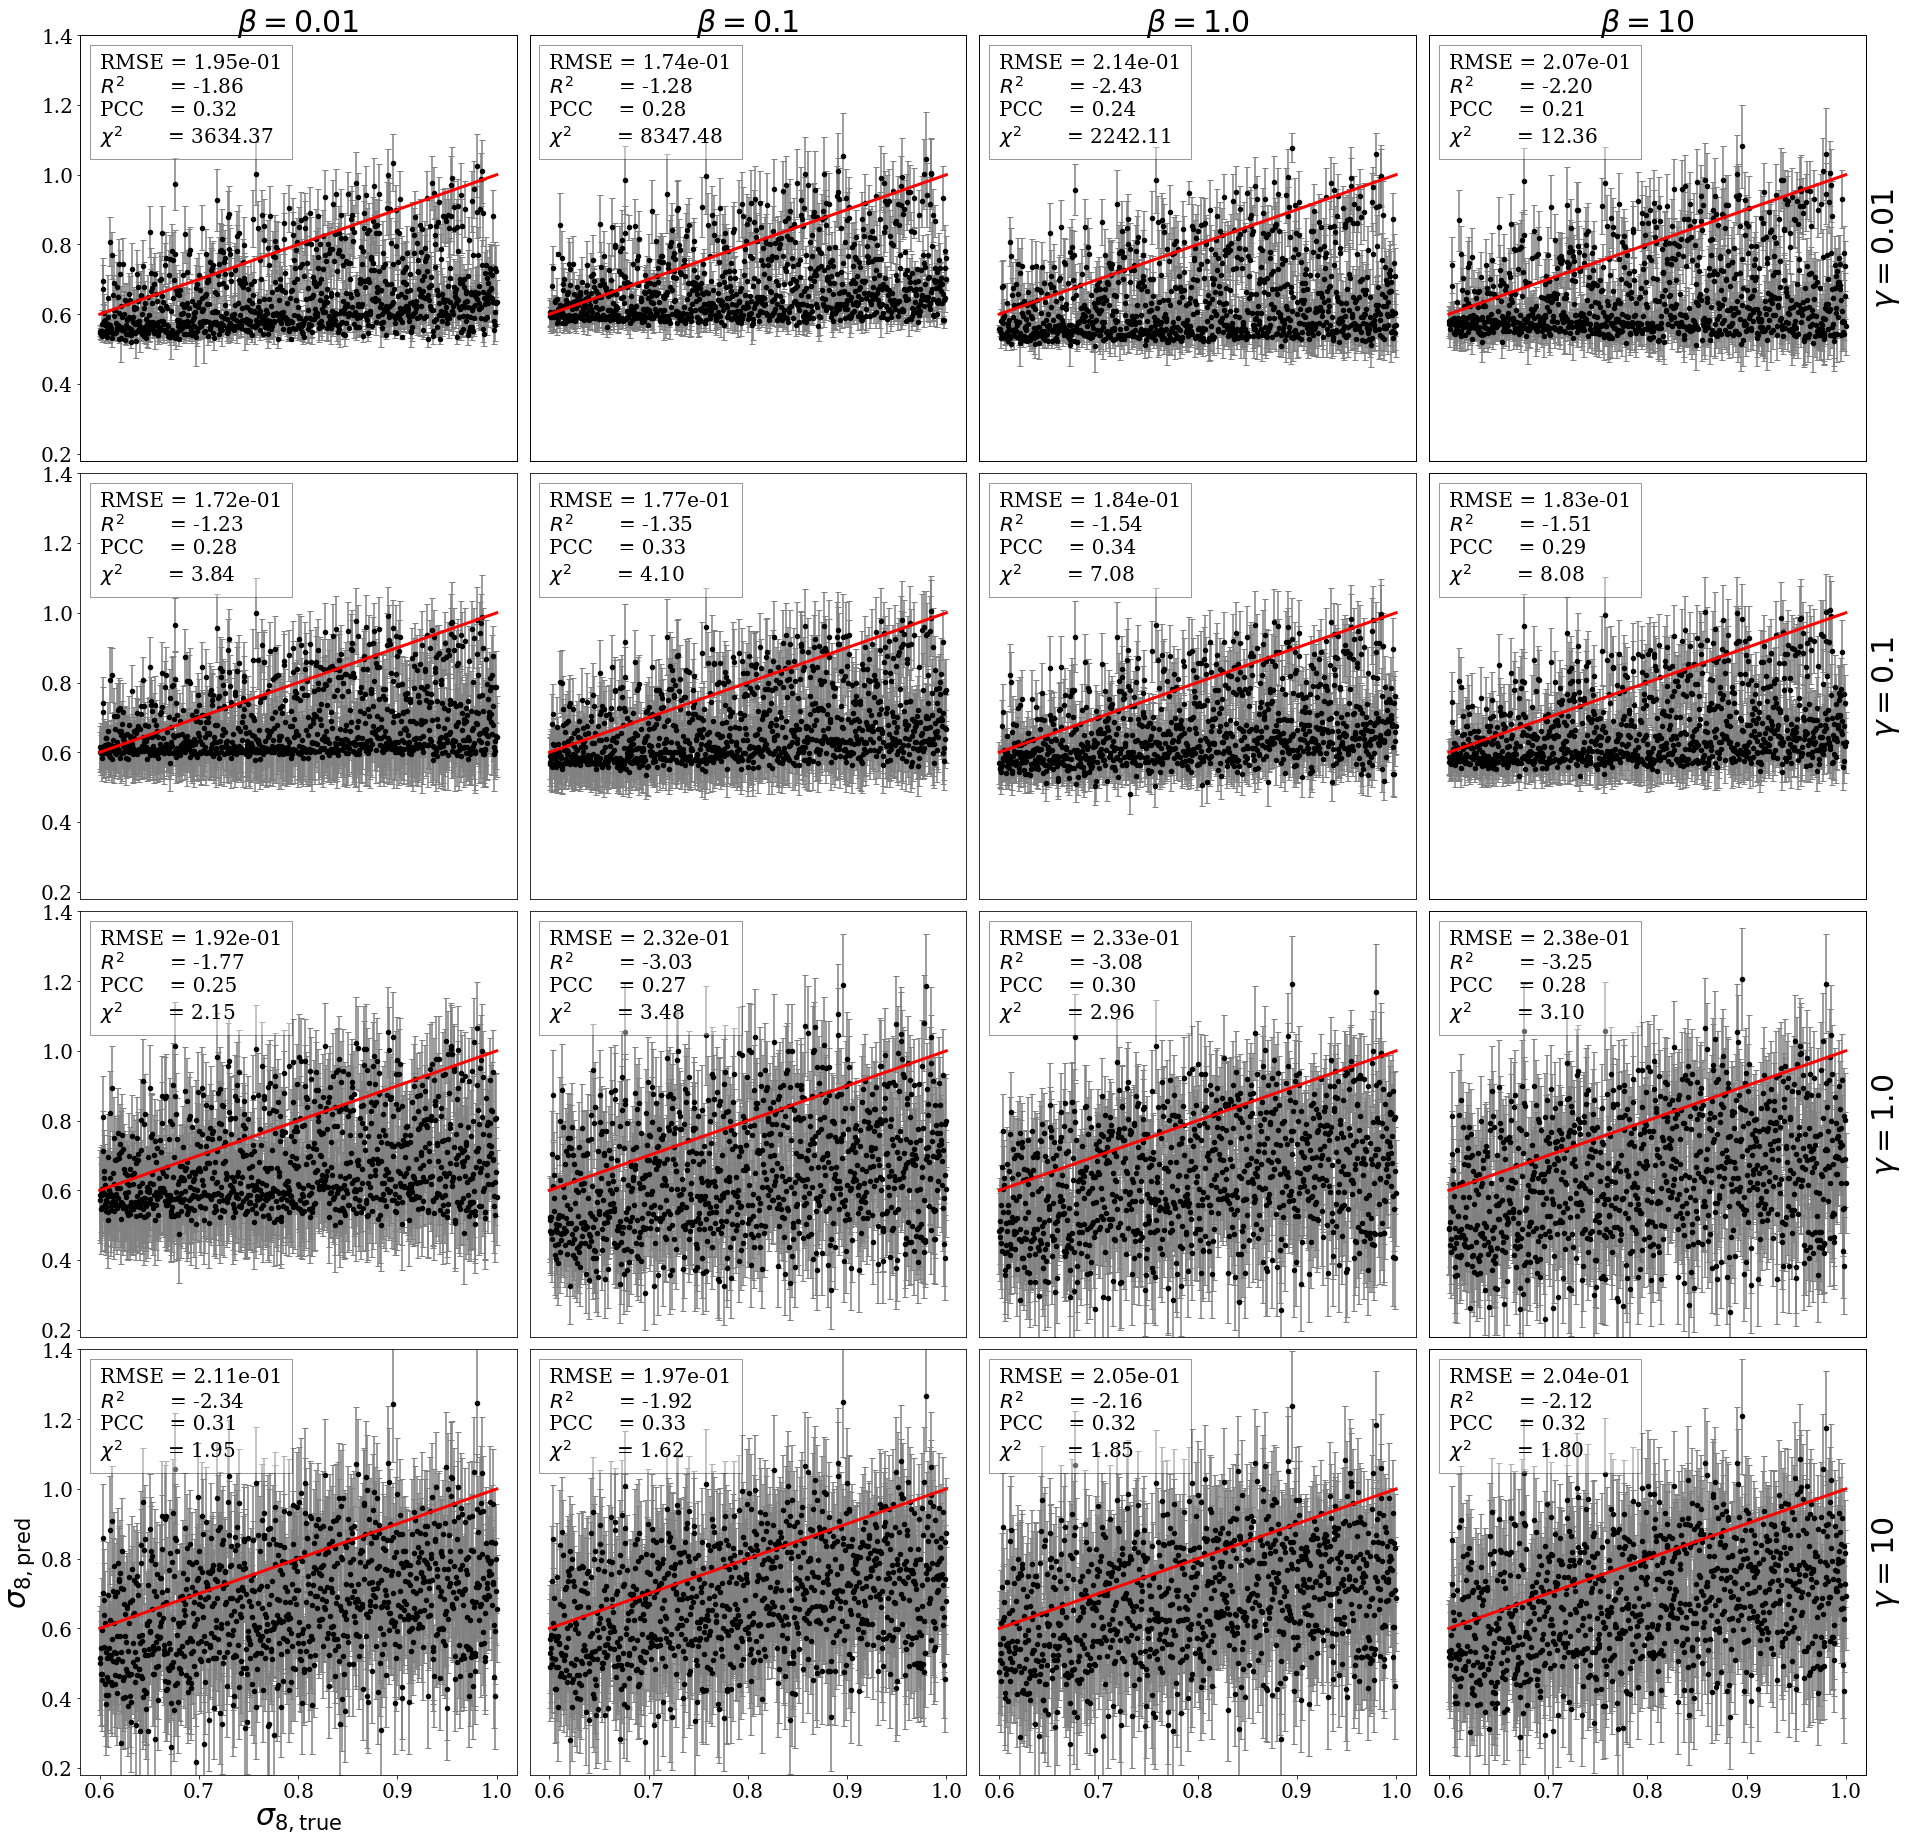

In [43]:
fig_shape = (4,4)
axes = generateAxesForMultiplePlots(shape=fig_shape,figsize=(32,32),wspace=0.03,hspace=0.03)
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fontsize = 30
ideal = np.linspace(0.1,0.5,3) if k == 0 else np.linspace(0.6,1.0,3)


betas  = [0.01,0.1,1.0,10]
gammas = [0.01,0.1,1.0,10]

for i in range(4):
    for j in range(4):
        beta, gamma = betas[i], gammas[j]
        y_true, y_pred = data[i,j]
        axes[i,j].errorbar(y_true[:,k], y_pred[0][:,k], y_pred[1][:,k],linestyle="None",ecolor="grey",
                         capsize=3,zorder=0)
        axes[i,j].scatter(y_true[:,k], y_pred[0][:,k],s=20,c='k', zorder=10)
        axes[i,j].plot(ideal,ideal,"r",lw=3,zorder=12)
        RMSE = np.sqrt(mean_squared_error(y_true[:,1], y_pred[0][:,1]))
        R2   = r2_score(y_true[:,1], y_pred[0][:,1])
        PCC  = pearsonr(y_true[:,1], y_pred[0][:,1])[0]
        CHI2 = np.mean((y_true[:,1]-y_pred[0][:,1])**2/y_pred[1][:,1]**2)
        text_om = \
        r"""{:<5}= {:.2e}
{:<12}= {:.2f}
{:<7}= {:.2f}
{:<15}= {:.2f}""".format("RMSE", RMSE,"$R^2$", R2,
                            "PCC", PCC, "$\chi^2$", CHI2)
        axes[i,j].text(0.6, 1.35, text_om, fontsize=20,
                       ha='left', va='top',bbox=dict(facecolor='white', alpha=0.4,pad=10),zorder=12)
        remove_inner_axes(axes,fig_shape)
        #axes[i,j].set_xlim(0.1,0.5)
        axes[i,j].set_ylim(0.18,1.4)
        if j == 0:
            ax = axes[i,j].twiny()
            ax.xaxis.tick_top()
            ax.set_xticks([])
            ax.set_xlabel(r"$\beta={}$".format(beta),fontsize=fontsize)
        if i == 3:
            ax = axes[i,j].twinx()
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel(r"$\gamma={}$".format(gamma),fontsize=fontsize)
axes[0,3].set_xlabel("$\sigma_\mathrm{8, true}$", fontsize=fontsize)
axes[0,3].set_ylabel("$\sigma_\mathrm{8, pred}$", fontsize=fontsize)
plt.savefig("Exploration_HI_sigma8.png", dpi=200, bbox_inches='tight')

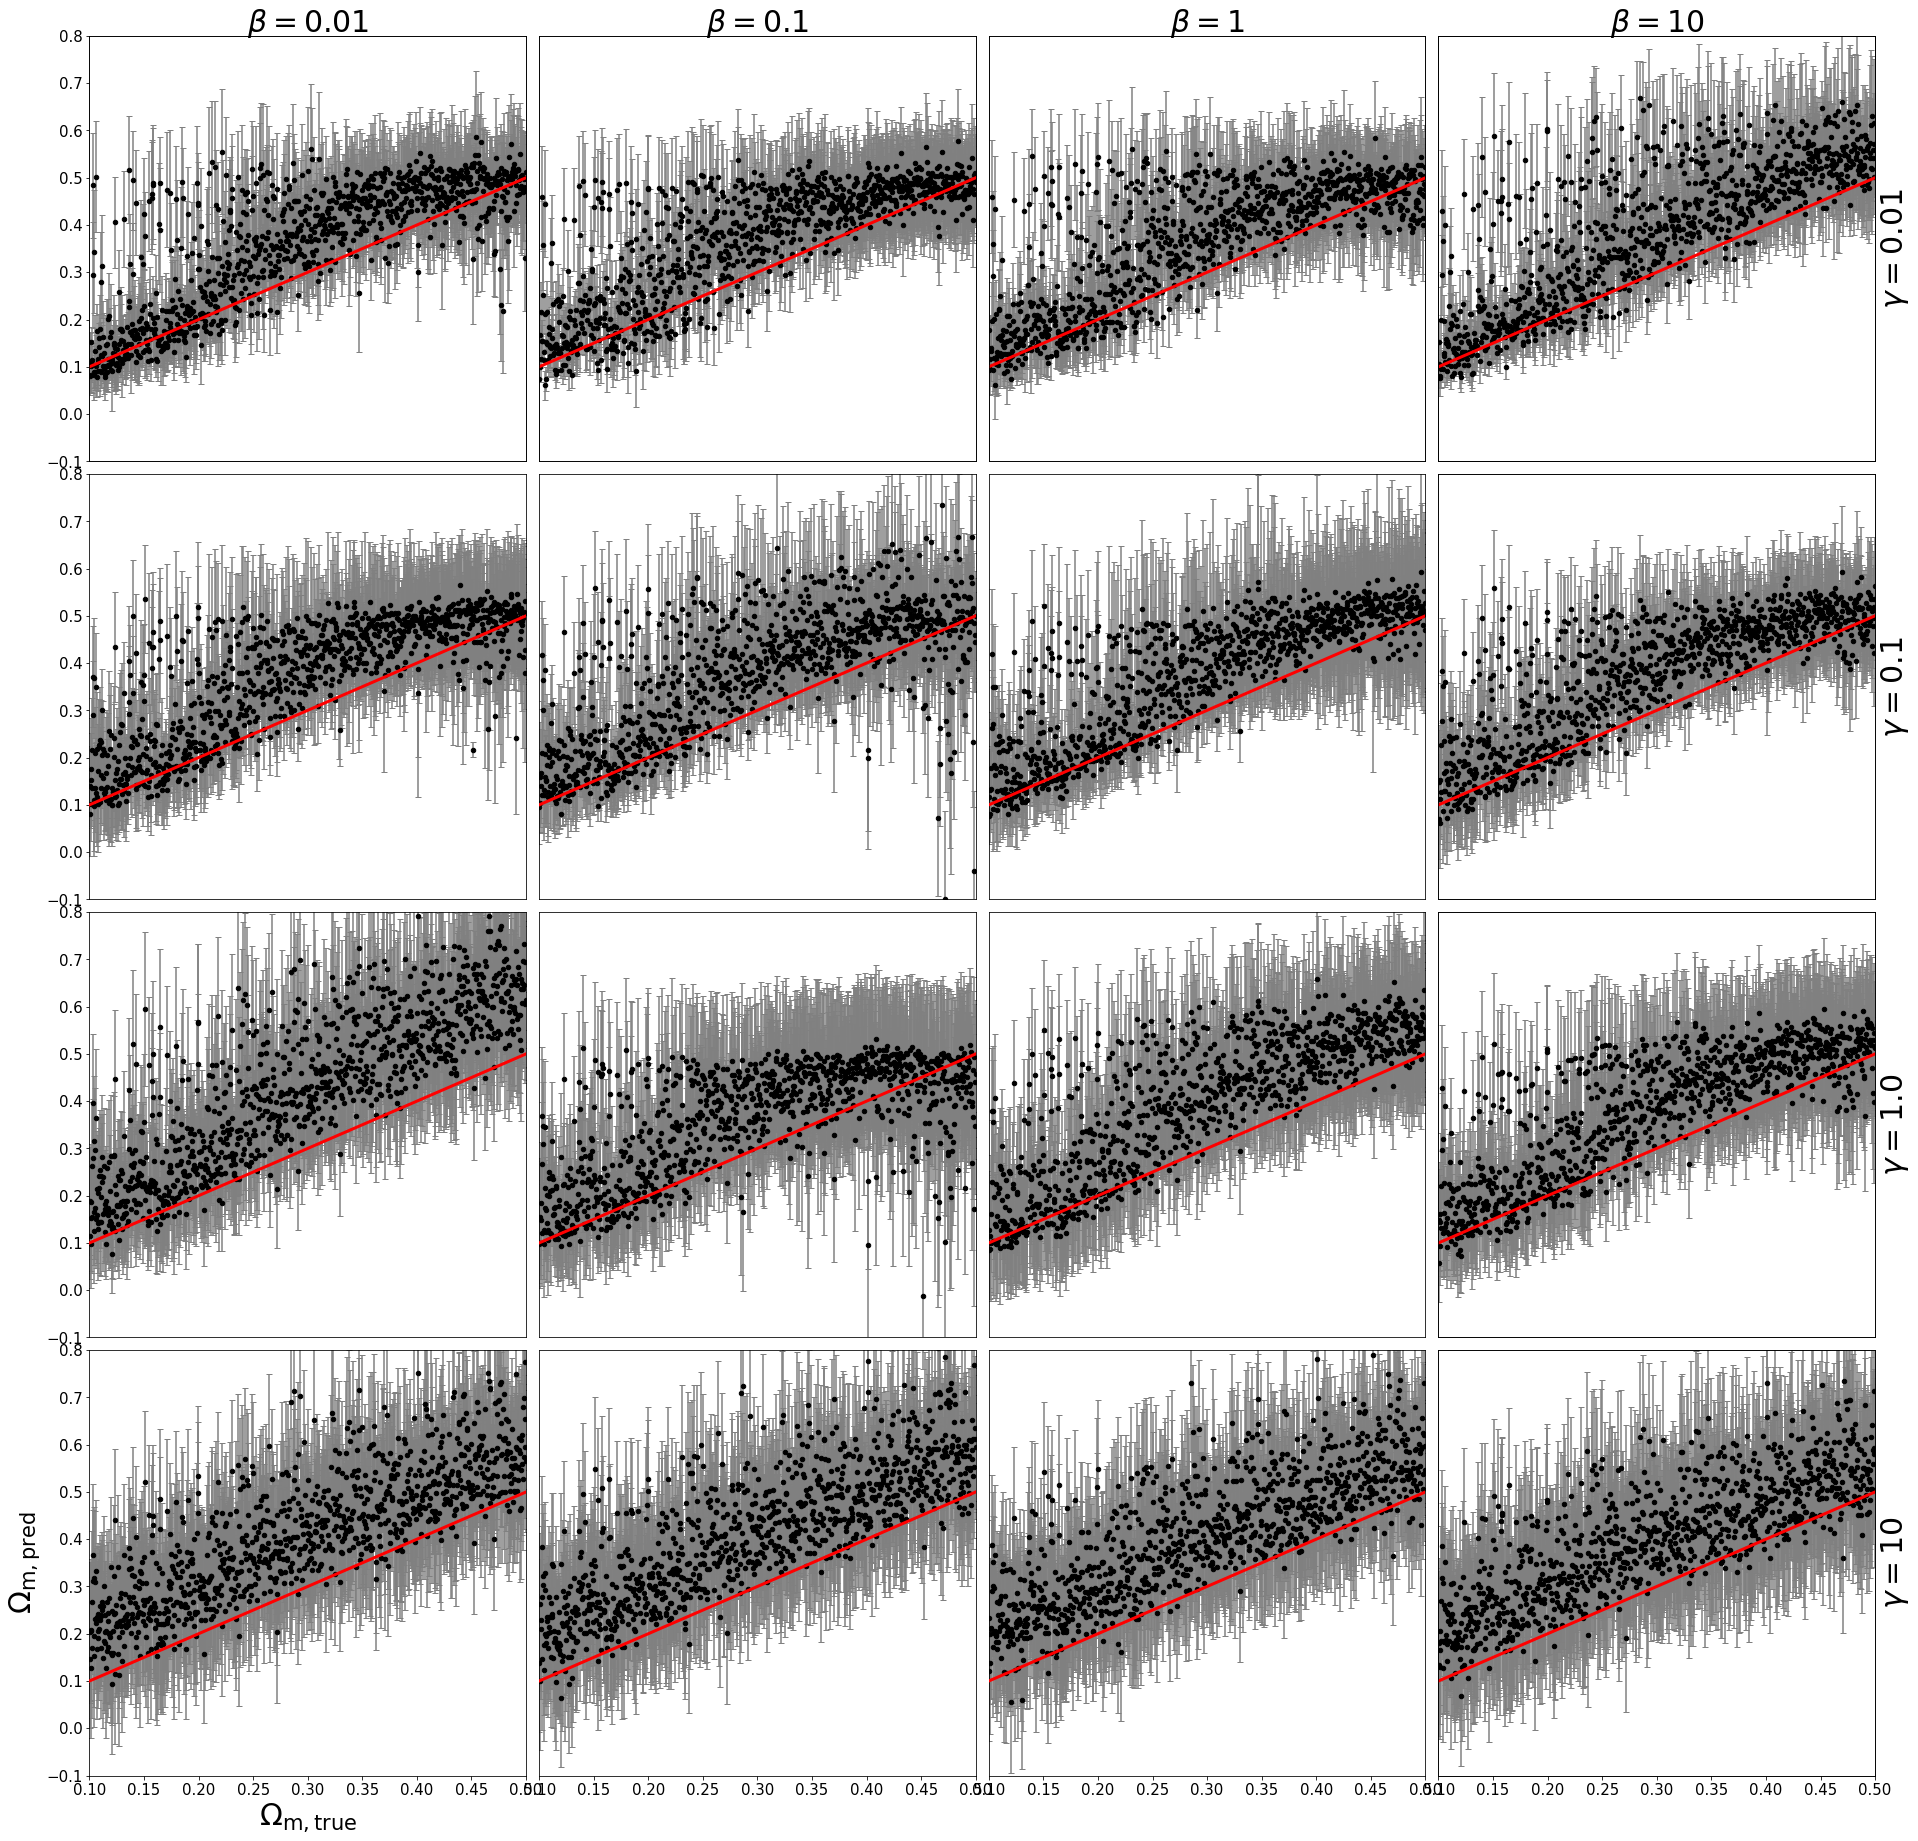

In [21]:
field = 'T';

fig_shape = (4,4)
axes = generateAxesForMultiplePlots(shape=fig_shape,figsize=(32,32),wspace=0.03,hspace=0.03)
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fontsize = 30
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.2,1.2,3)


betas  = [0.01,0.1,1,10]
gammas = [0.01,0.1,1.0,10]

for i in range(4):
    for j in range(4):
        beta, gamma = betas[i], gammas[j]
        fname = "search/TNG+SIMBA_{}_beta_{}_gamma_{}".format(field, beta, gamma)
        mist = MIST(sim=["TNG","SIMBA"],field=field, extended_L=False)
        mist.load_models(which_machine='vib+cls', fname=fname, z_dim=1000)
        y_true, y_pred = mist.test_on(sims="ASTRID", fname="0.01", data_return=True,show_plot=False, show_score=False, save_plot=False)
        axes[i,j].errorbar(y_true[:,0], y_pred[0][:,0], y_pred[1][:,0],linestyle="None",ecolor="grey",
                         capsize=3,zorder=0)
        axes[i,j].scatter(y_true[:,0], y_pred[0][:,0],s=20,c='k', zorder=10)
        axes[i,j].plot(ideal1,ideal1,"r",lw=3,zorder=12)
        remove_inner_axes(axes,fig_shape)
        axes[i,j].set_xlim(0.1,0.5)
        axes[i,j].set_ylim(-0.1,0.8)
        if j == 0:
            ax = axes[i,j].twiny()
            ax.xaxis.tick_top()
            ax.set_xticks([])
            ax.set_xlabel(r"$\beta={}$".format(beta),fontsize=fontsize)
        if i == 3:
            ax = axes[i,j].twinx()
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel(r"$\gamma={}$".format(gamma),fontsize=fontsize)
axes[0,3].set_xlabel("$\Omega_\mathrm{m, true}$", fontsize=fontsize)
axes[0,3].set_ylabel("$\Omega_\mathrm{m, pred}$", fontsize=fontsize)
plt.savefig("Exploration_{}_omegam.png".format(field), dpi=200, bbox_inches='tight')

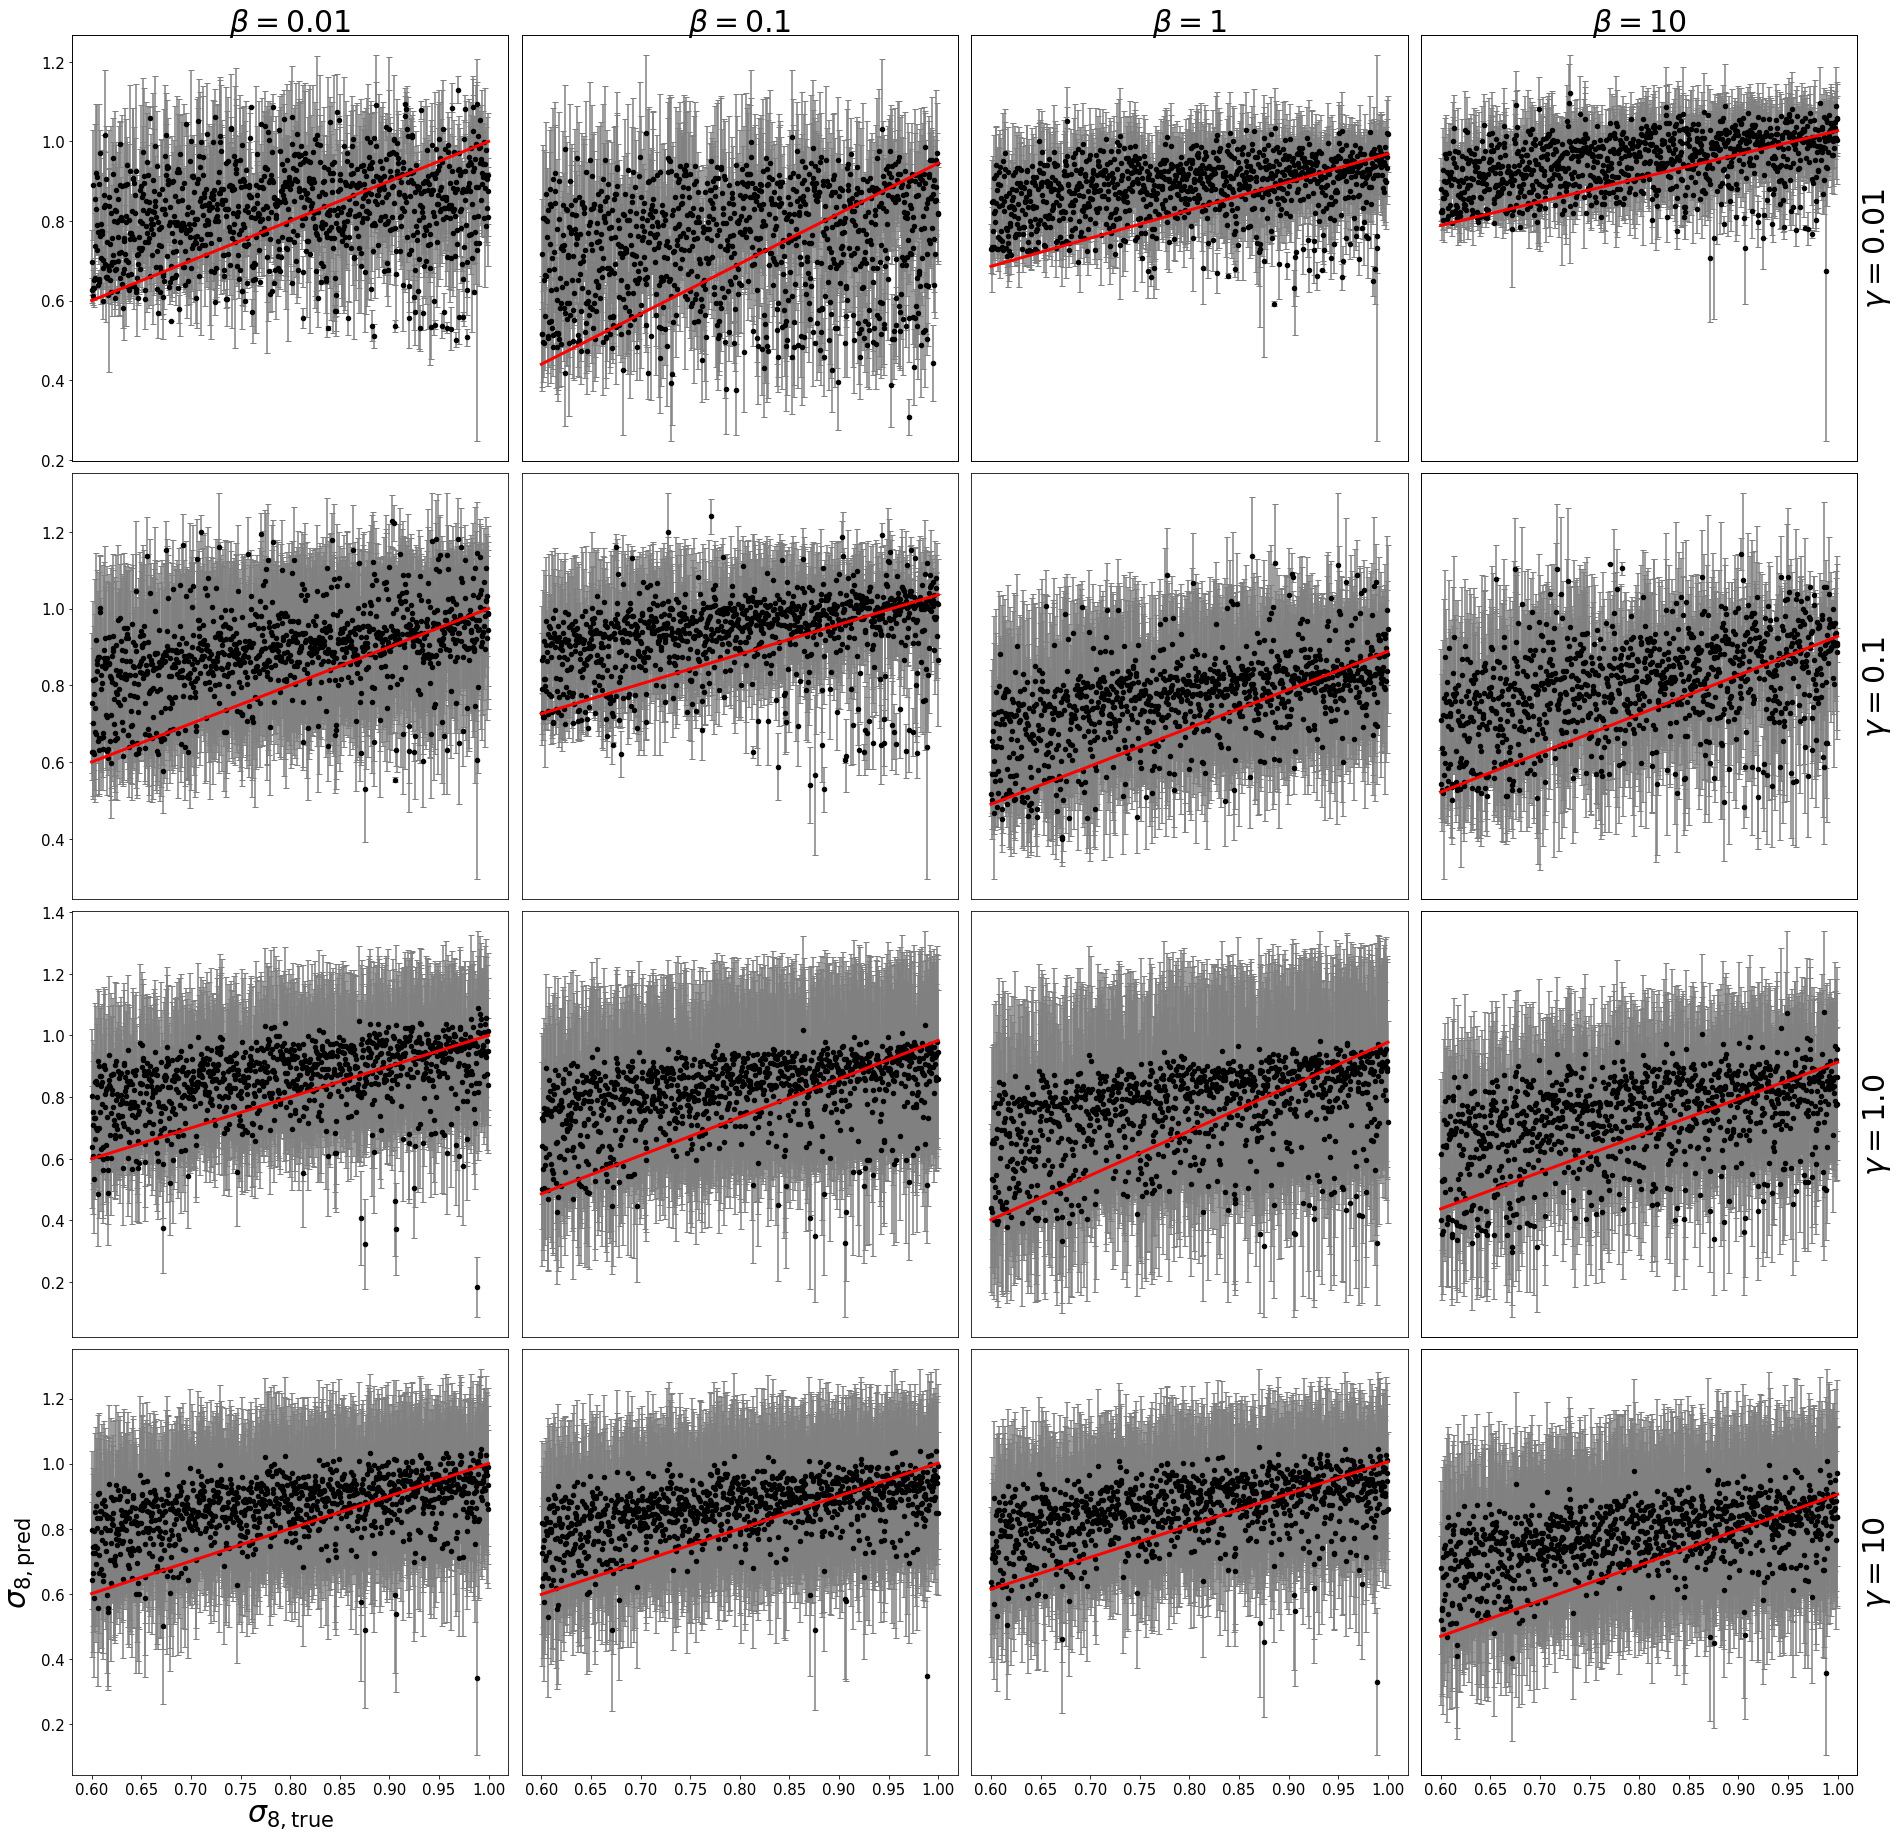

In [20]:
field = 'T'; k = 1;

fig_shape = (4,4)
axes = generateAxesForMultiplePlots(shape=fig_shape,figsize=(32,32),wspace=0.03,hspace=0.03)
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fontsize = 30
ideal = np.linspace(0.1,0.5,3) if k == 0 else np.linspace(0.6,1.0,3)


betas  = [0.01,0.1,1,10]
gammas = [0.01,0.1,1.0,10]

for i in range(4):
    for j in range(4):
        beta, gamma = betas[i], gammas[j]
        fname = "search/TNG+SIMBA_{}_beta_{}_gamma_{}".format(field, beta, gamma)
        mist = MIST(sim=["TNG","SIMBA"],field=field, extended_L=False)
        mist.load_models(which_machine='vib+cls', fname=fname, z_dim=1000)
        y_true, y_pred = mist.test_on(sims="ASTRID", fname="0.01", data_return=True,show_plot=False, show_score=False, save_plot=False)
        axes[i,j].errorbar(y_true[:,k], y_pred[0][:,k], y_pred[1][:,k],linestyle="None",ecolor="grey",
                         capsize=3,zorder=0)
        axes[i,j].scatter(y_true[:,k], y_pred[0][:,k],s=20,c='k', zorder=10)
        axes[i,j].plot(ideal,ideal,"r",lw=3,zorder=12)
        remove_inner_axes(axes,fig_shape)
        #axes[i,j].set_xlim(0.1,0.5)
        #axes[i,j].set_ylim(-0.1,0.8)
        if j == 0:
            ax = axes[i,j].twiny()
            ax.xaxis.tick_top()
            ax.set_xticks([])
            ax.set_xlabel(r"$\beta={}$".format(beta),fontsize=fontsize)
        if i == 3:
            ax = axes[i,j].twinx()
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel(r"$\gamma={}$".format(gamma),fontsize=fontsize)
axes[0,3].set_xlabel("$\sigma_\mathrm{8, true}$", fontsize=fontsize)
axes[0,3].set_ylabel("$\sigma_\mathrm{8, pred}$", fontsize=fontsize)
plt.savefig("Exploration_{}_sigma8.png".format(field), dpi=200, bbox_inches='tight')

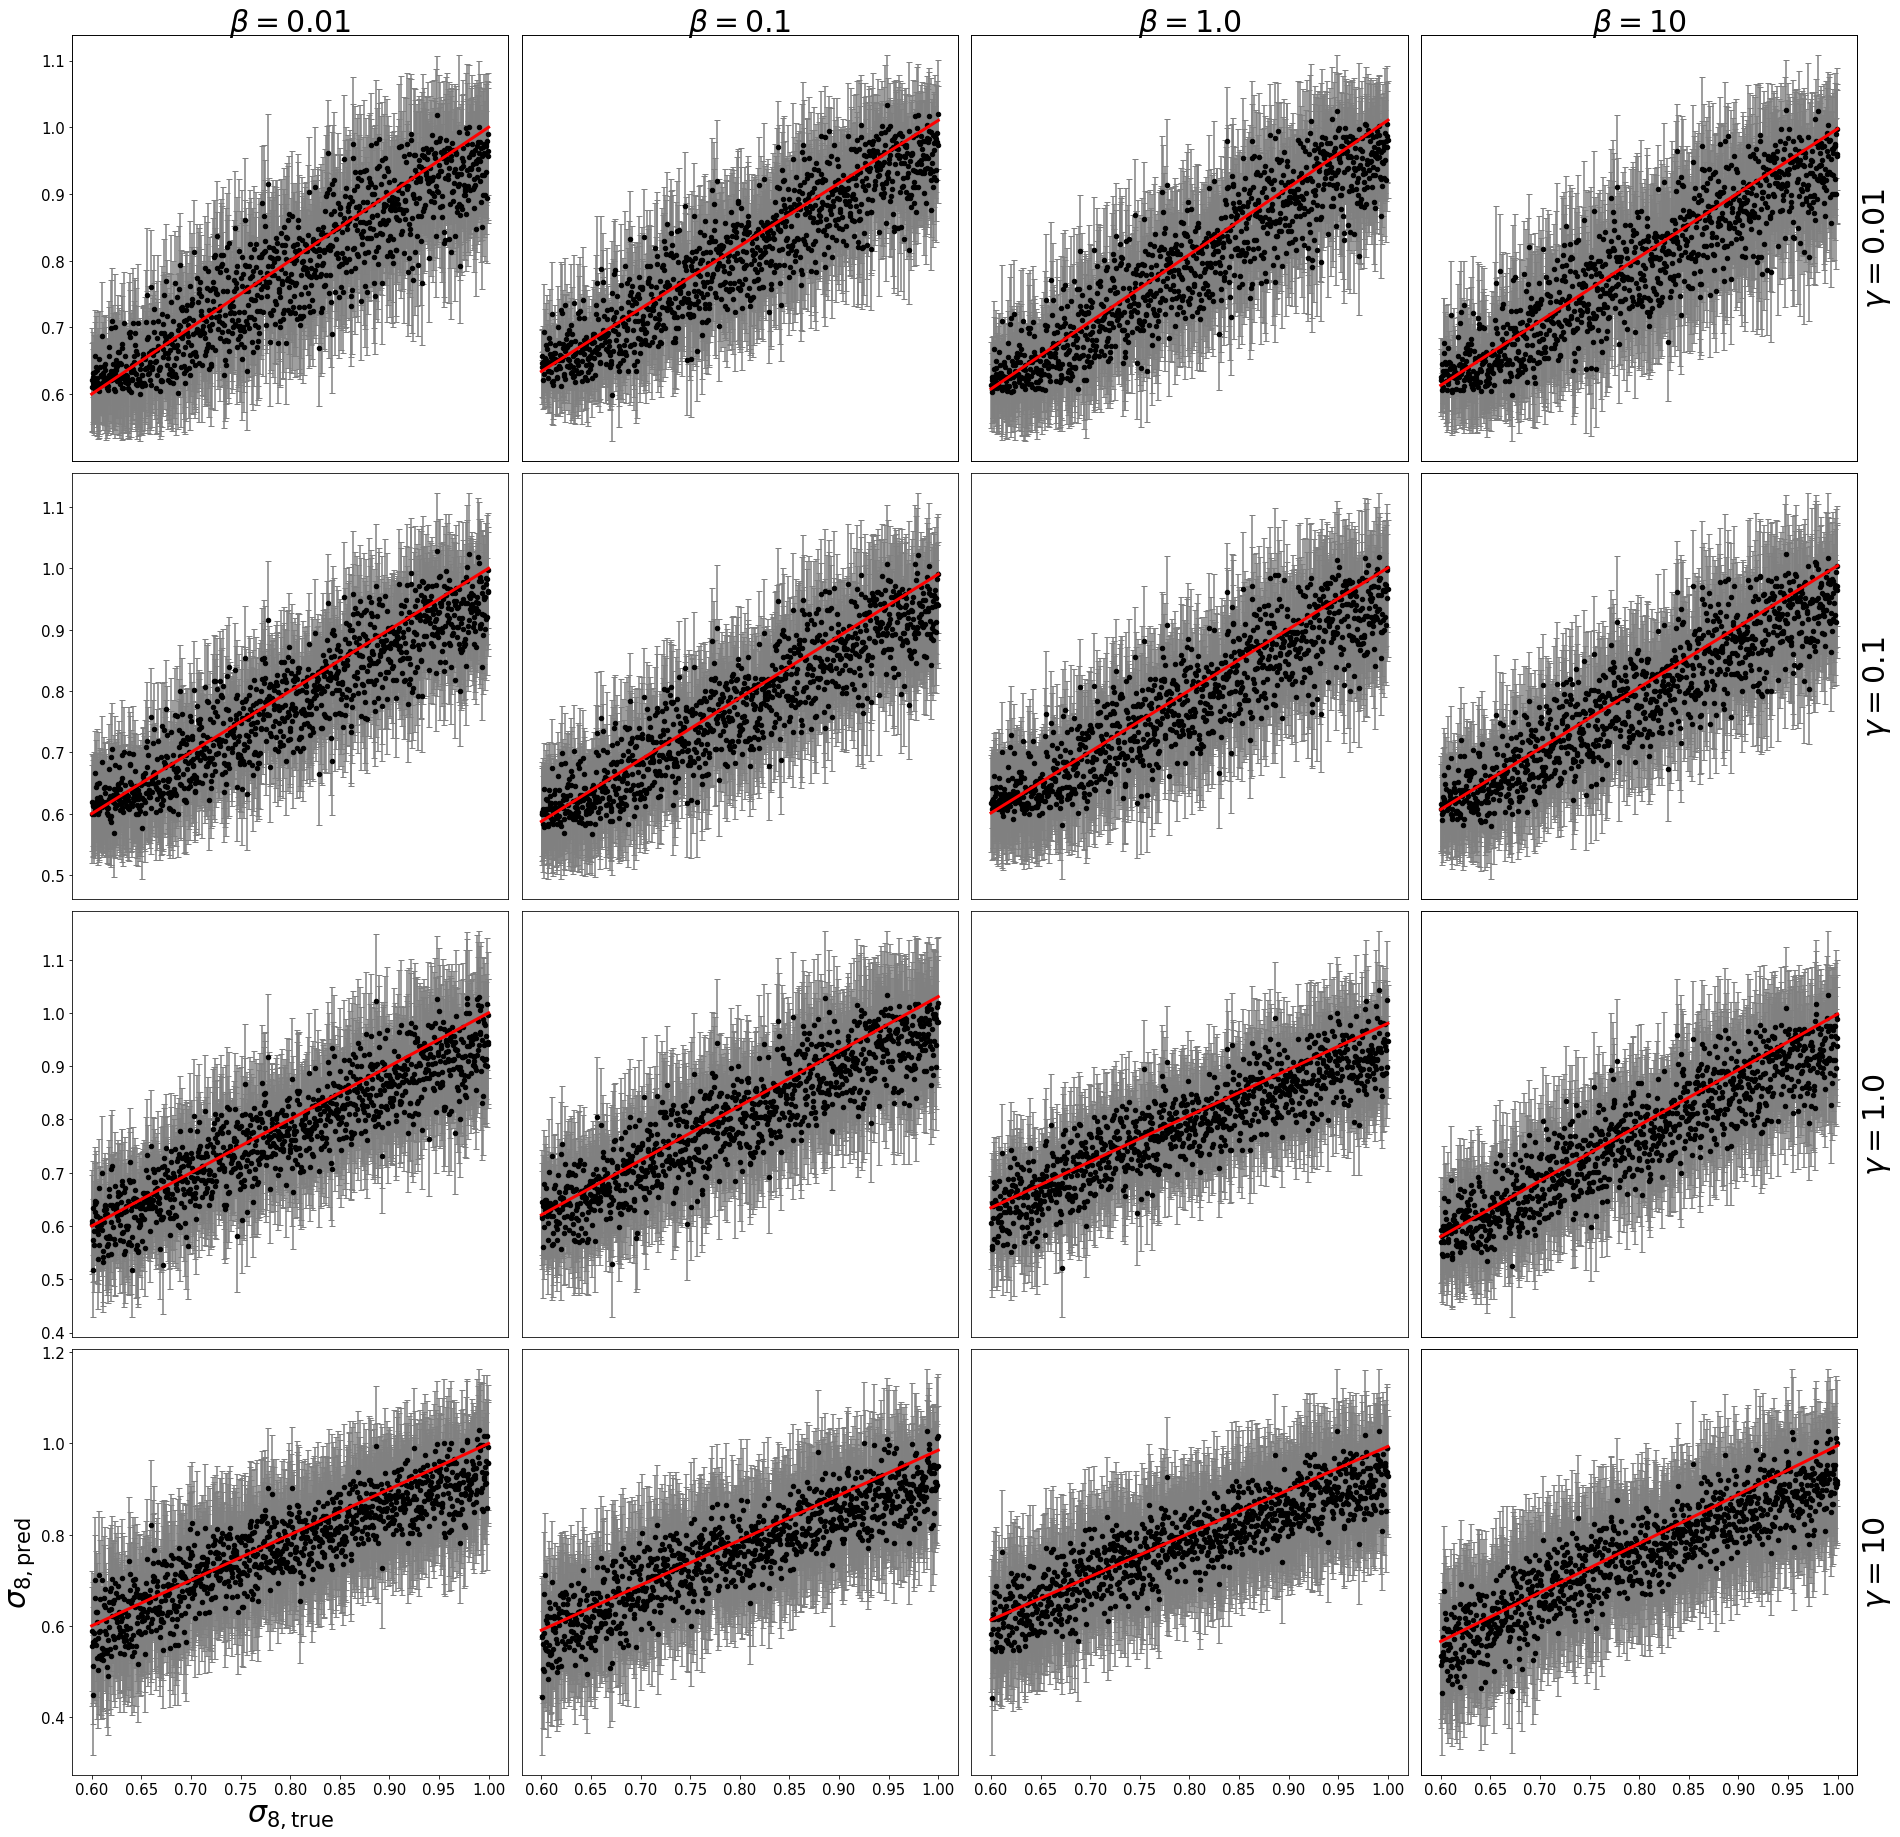

In [22]:
field = 'Mtot'; k = 1;

fig_shape = (4,4)
axes = generateAxesForMultiplePlots(shape=fig_shape,figsize=(32,32),wspace=0.03,hspace=0.03)
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fontsize = 30
ideal = np.linspace(0.1,0.5,3) if k == 0 else np.linspace(0.6,1.0,3)


betas  = [0.01,0.1,1.0,10]
gammas = [0.01,0.1,1.0,10]

for i in range(4):
    for j in range(4):
        beta, gamma = betas[i], gammas[j]
        fname = "search/TNG+SIMBA_{}_beta_{}_gamma_{}".format(field, beta, gamma)
        mist = MIST(sim=["TNG","SIMBA"],field=field, extended_L=False)
        mist.load_models(which_machine='vib+cls', fname=fname, z_dim=1000)
        y_true, y_pred = mist.test_on(sims="ASTRID", fname="0.01", data_return=True,show_plot=False, show_score=False, save_plot=False)
        axes[i,j].errorbar(y_true[:,k], y_pred[0][:,k], y_pred[1][:,k],linestyle="None",ecolor="grey",
                         capsize=3,zorder=0)
        axes[i,j].scatter(y_true[:,k], y_pred[0][:,k],s=20,c='k', zorder=10)
        axes[i,j].plot(ideal,ideal,"r",lw=3,zorder=12)
        remove_inner_axes(axes,fig_shape)
        #axes[i,j].set_xlim(0.1,0.5)
        #axes[i,j].set_ylim(-0.1,0.8)
        if j == 0:
            ax = axes[i,j].twiny()
            ax.xaxis.tick_top()
            ax.set_xticks([])
            ax.set_xlabel(r"$\beta={}$".format(beta),fontsize=fontsize)
        if i == 3:
            ax = axes[i,j].twinx()
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel(r"$\gamma={}$".format(gamma),fontsize=fontsize)
axes[0,3].set_xlabel("$\sigma_\mathrm{8, true}$", fontsize=fontsize)
axes[0,3].set_ylabel("$\sigma_\mathrm{8, pred}$", fontsize=fontsize)
plt.savefig("Exploration_{}_sigma8.png".format(field), dpi=200, bbox_inches='tight')